In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display_javascript

from vis_common import load_store, load_games

FS = (10, 6) # Reasonable default figsize
DECILES = list(np.arange(0.1, 1.0, 0.1))

store = load_store()
g = games = load_games()

It sure would be useful to be able to assign to each DCSS player a measure of their skill.

Why? Let's say we have some hypothesis about some gameplay decision, like...

- Abyssal is usually a safer third rune than Silver
- Maces are the best weapon type for Gargoyle Fighters
- The best use of scrolls of acquirement is to acquire food

One simple way to evaluate these kinds of claims is by looking at the games where $choice occurred (e.g. the games where the player went for abyssal as their third rune, or GrFi games where the player focused on maces), and seeing how many of them ended in victory, compared to games where the alternative occurred. 

The problem with this approach is that it uses a signal (wins) which is sparse and noisy. **Sparse** because DCSS is a hard game. On the whole, less than 1 in 100 games results in a win. **Noisy** because games involve a lot of decisions (and randomness). The effect of any one decision on whether that game is won is going to be pretty small. 

In some cases, we might find it easier to **just ask what skilled players do**. "How often do strong players take the Abyssal rune as their third?" "Do strong players specialize in maces more often when playing GrFis?"

By assigning a varied range of 'skill' scores to players, we no longer have the problem of sparsity. Even if games A and B were both lost, we can say that A was 'better' if it was played by a player with a 5% win rate, and B was played by someone with a 0.5% win rate.

(Also, knowing whether a particular behaviour is strongly associated with experienced/inexperienced players is interesting in its own right, even if we're not trying to make any claims about a causal effect on winning.)

## Skill ≈ Win rate?

The most obvious measure of player skill would just be their raw win rate: `n_wins / n_games`. 

However, as I showed in my post on [Players of DCSS](/blog/dcss_players#Winrates), the distribution of winrates is spiky. 

In [2]:
print "Distribution of win rates (as %) across players...\n"
wrpp = g.groupby('pid')['won'].mean().rename('winrate')
print (100*wrpp).describe([.5, .9, .925, .95, .975, .99, .995])

Distribution of win rates (as %) across players...

count    26004.000000
mean         0.605308
std          5.030780
min          0.000000
50%          0.000000
90%          0.000000
92.5%        0.236466
95%          1.265480
97.5%        4.166125
99%         14.574405
99.5%       31.988750
max        100.000000
Name: winrate, dtype: float64


On the low end, it's concerning that we're assigning the same score of 0 to over 90% of players. Intuitively, it seems like there should be room for differentiation among those who have never won a game. Player A, with 0 wins out of 300 games should probably be ranked lower than B with 0 wins out of 2 games. We have pretty strong evidence that A has a low winrate. But B's record is not at all inconsistent with them having, say, a 10% winrate.

On the high end, there's reason to be concerned about artificially high win rates. We have 37 players with a 1 win 0 losses record - if we made them play 10 more games each, do we really expect they would win them all?

This is basically the same problem as [sorting starred product reviews](http://www.evanmiller.org/how-not-to-sort-by-average-rating.html). The bread machine with a single 5-star review should probably not be ranked higher than the one with 100 reviews averaging 4.9 stars.

## Solution: Bayesian estimate of win rate

I'm going to try to estimate each player's 'true' win rate - i.e. the proportion of games they would win if we sat them down to play DCSS for eternity.

## Assumptions

Before I get into the math, it's worth pointing out a few (shaky) assumptions I'm relying on.

### Assumption 1: Static win rate per player

My model assumes that each player has a fixed 'true' win rate, and that each game played is an independent Bernoulli trial. Baloney!

Players probably tend to improve with experience. (We could try to account for this by assigning players a series of win rates, by applying a moving window to their game history, with the contribution of a game decaying with its distance from the focal game.)

### Assumption 2: Winning is everything

In the abstract, the goal of DCSS is to win. Therefore, by definition, player A is better than player B if and only if they are more able to win the game.

Where does this fall apart? The Crawl community values versatility. The prized titles of ["great/greater player"](https://crawl.develz.org/tavern/viewtopic.php?f=5&t=20762) have nothing to do with winrate - they're earned by winning a game with each species/background. 

We could try to make our definition of DCSS skill better match the community's, by defining it as a player's ability to win the game, averaged over all species/bg combinations. But this would make things a lot more complicated - now we're estimating ~26<sup>2</sup> parameters per player, rather than 1.

A simpler way to account for this would be to assign a different prior to each game according to the chosen species and background (e.g. the win rate over all games is 0.74%, but for just Minotaur Fighter games, it's 1.17%). This could even take into account the game version. The effect of a given game on a player's score would scale with how surprised we are at the outcome. A MuWn win might be worth more points than a MiFi win. And a MuWn loss might have a less negative effect on a player's score than a MiFi loss. This wouldn't explicitly reward versatility, but it would at least avoid punishing it.

Many would also agree that, all else being equal, a win is more impressive that...

- earns more runes
- takes fewer turns
- takes less wall-clock time

### Assumption 3: Players are trying to win

Above, we said that a player's skill at DCSS corresponds to their "ability to win". Assumption 3 is what lets us equate "probability of winning a given game" with "ability to win a given game".

The fact that players ever choose challenging starting conditions (e.g. Mummy Wanderer) already shows they're not simply trying to maximize their chances of winning. Also...

- Players may incur a high risk of losing to get 15 runes, even though they could easily win from their present position.
- Some players may adopt faster, riskier playstyles early in the game, because they don't mind losing a character they haven't invested much time in.
- Players may just quit a character out of boredom.
- Players might make throwaway characters to test something, then splat them when they're done. (My analysis excludes games that were quit at level 1, but a test character might die after that, or the player might just let themselves get clubbed to death by a kobold rather than quitting with ctrl+Q).

## Estimating win rate

### What's wrong with raw win rate?

We rejected raw win rate because it gives some dumb estimates to players with a small number of games played, such as giving a 100% win rate to players with a record of 1 win 0 losses. What allows us to call that dumb? We have some **prior knowledge** of win rates. We know that DCSS is a hard game, and that a win rate over 90% is *very* unlikely - much less likely than the player having a 1% win rate and getting lucky on their one game.

An alien observing a coin coming up heads 4 times out of 5 flips might guess that the coin has $P(heads) = .8$. This is the parameterization that maximimizes the likelihood of that observation, so it's a good guess if you have no idea how coins work. On the other hand, someone who's flipped a lot of coins might guess that $P(heads) = .5$, based on a strong prior belief that coins are usually fair.

Let's try to come up with a concrete representation of our prior belief about DCSS win rates.

### Defining a prior

By a prior distribution on win rates, we mean some function that, given a win rate, tells us how likely it is. 

A [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) turns out to be a good choice for this kind of thing. The Beta distribution assigns probabilities to values in the range [0, 1], which can themselves be thought of as probabilities. It's like a distribution over (Bernoulli) distributions (a [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior_distribution) if you want to get fancy). In this case, the probabilities we're assigning probabilities to are *win rates*.

Beta distributions are defined by two parameters, $\alpha$ and $\beta$. The mean is given by

$$\frac {\alpha} {\alpha + \beta}$$

Let's call the mean of our prior distribution $\pi$. We can equivalently define a unique Beta distribution by choosing a value for $\pi$, and for a 'concentration parameter' $C = \alpha + \beta$. 

$C$ controls the strength of our prior belief. The higher $C$ is, the more tightly our distribution will concentrate around $\pi$.

(This reparameterization will turn out to be useful in a moment.)


### Calculating smoothed win rate

After observing a player play $n$ games and win $w$ times, we'll get a **posterior distribution** over that player's win rate, which combines our prior belief about win rates in general with the new evidence we've seen about this specific player's ability.

I won't go through the derivation here (check out [this wiki article](https://en.wikipedia.org/wiki/Conjugate_prior#Example) if you're interested), but it turns out that the posterior we get is just another Beta distribution, with $\alpha = \alpha_{prior} + w$ and $\beta = \beta_{prior} + n - w$.

The mean of this posterior distribution, our win rate estimate for this player, is

$$wr = \frac {\alpha_{prior} + w} {\alpha_{prior} + \beta_{prior} + n}$$

Which can be rewritten as...

$$\frac {C \pi + w} {C + n}$$

A simple way to think about this is that, when calculating this player's (smoothed) win rate, we're padding our calculation with $C$ additional games ("pseudo-events") having win rate $\pi$.


### Choosing prior distribution parameters 

For $\pi$, I'll just use the win rate over all games in the dataset (0.74%). I could also have gone with the "macro-averaged" win rate (the average win rate across players - an average of averages), which is about .1% lower. If number of games played is independent of win rate, these should both be unbiased estimates, but the former should have less variance. (Unfortunately, we have pretty strong evidence that there is a positive correlation between winrate and number of games played, so our estimate is probably too optimistic.)

$C$ is a bit more subtle. Let's just start it out at 10, and see what that looks like for some examples.

In [4]:
wr_prior = g['won'].mean()
# Controls the strength of the smoothing
C = 10
def smooth(wins, games):
    return 100 * (
        (wins + (C * wr_prior))
        /
        (C + games)
    )

wg = [
    (0, 1), (1, 1), (0, 10), (0, 50), (0, 500), (1, 500), (1, 10), (5, 50), (20, 200),
]
print "Smoothed winrate examples (C={}, pi={:.2f}%)...\n".format(C, wr_prior*100)
for (wi, ga) in wg:
    print "{} wins / {} games:\twr = {:.2f}%".format(wi, ga, smooth(wi, ga))

Smoothed winrate examples (C=10, pi=0.74%)...

0 wins / 1 games:	wr = 0.67%
1 wins / 1 games:	wr = 9.76%
0 wins / 10 games:	wr = 0.37%
0 wins / 50 games:	wr = 0.12%
0 wins / 500 games:	wr = 0.01%
1 wins / 500 games:	wr = 0.21%
1 wins / 10 games:	wr = 5.37%
5 wins / 50 games:	wr = 8.46%
20 wins / 200 games:	wr = 9.56%


C=10 basically means that a player with 10 games will be assigned a score halfway between their raw winrate and the overall average. If you have 90 games, 90% of your score will come from your actual winrate, and 10% from our padding. With just 1 game, your score will be much closer to the overall average than to your raw win rate of 0% or 100%.

This looks pretty reasonable. We can sort of justify C=10 on the basis that 10 games feels like a reasonable amount of padding, but 5 or 50 don't necessarily seem unreasonable either.

One way we can empirically evaluate a prior is just graphing it against our observed win rates. What we're trying to model is the distribution of "true" win rates across players, and unfortunately we can't sample a single value from that distribution. But, we can treat our observed win rates as noisy samples from that distribution - and by only drawing from players with at least, say, 100 games, we can limit their noisiness.

Let's start by plotting a Beta distribution with $C=1$ - i.e. just a single pseudo-event.

In [3]:
import winrate
g['raw winrate'] = g.groupby('pid')['won'].mean().loc[g['pid']].values
g['wr'] = winrate.smoothed_winrate(g)
#print "Distribution of raw/smoothed winrates over players...\n"
#print (100*g.groupby('pid')[['raw winrate', 'wr']].mean()).rename(columns={'wr': 'smoothed winrate'})\
#    .describe([.1, .25, .5, .75, .9, .95, .975, .99, .995])
rwrpp = g.groupby('pid')['raw winrate'].first()
wrpp = g.groupby('pid')['wr'].first()

In [4]:
from scipy.stats import beta
gpp = games_per_pid = g.groupby('pid').size()
wpp = wins_per_pid = g.groupby('pid')['won'].sum()
thresh = 100
pids = gpp[gpp >= thresh].index
foo = g[g['pid'].isin(pids)].groupby('pid')['raw winrate'].mean()

In [7]:
C = 1
a=wr_prior*C
b=(1-wr_prior)*C
mult = 5
B = beta.rvs(a=a, b=b, size=len(foo)*mult)
print ("Plotting cumulative density of Beta distribution with a={:.3f} b={:.2f} vs. "
       "raw win rates for {} players having at least {} games".format(a, b, len(foo), thresh))

Plotting cumulative density of Beta distribution with a=0.007 b=0.99 vs. raw win rates for 2644 players having at least 100 games


In [8]:
def plot_winrates(C=10, prior=(0,0), ax=None):
    a=wr_prior*C + prior[0]
    b=(1-wr_prior)*C + prior[0]
    mult = 1
    B = beta.rvs(a=a, b=b, size=len(foo)*mult)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    order = 1
    y1 = np.arange(len(foo)) / len(foo)
    y2 = np.arange(len(foo)*mult) / (len(foo)*mult)
    ax.step(np.sort(foo.values)[::order], y1, label='actual', alpha=.5)
    ax.step(np.sort(B)[::order], y2, label='theoretical', alpha=.5)
    ax.vlines(wr_prior, *ax.get_ylim(), label='prior winrate', linestyle="--", lw=.5)
    ax.hlines(0.5, *ax.get_xlim(), label='median', linestyle=":", lw=.5)
    ax.legend()
    ax.set_ylabel('cumulative density')
    return ax

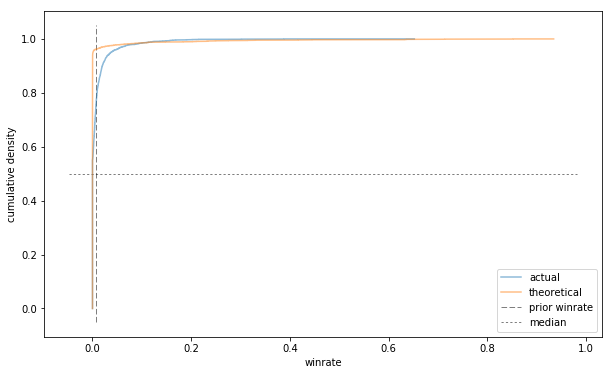

In [9]:
ax = plot_winrates(C=1)
ax.set_xlabel('winrate');

It's a bit hard to tell what's going on here because so much of the action is happening at the far left (as it should - we know that win rates over 10% are exceedingly rare).

Here's the same thing with a log x scale.

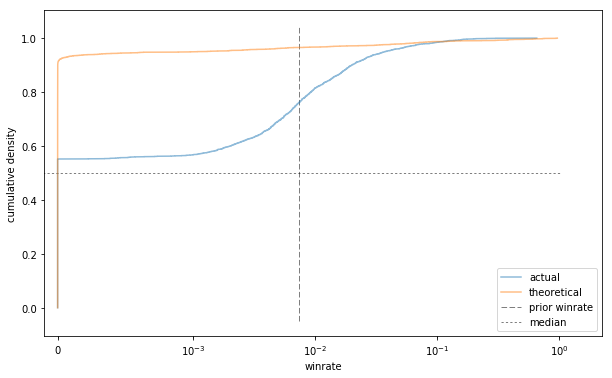

In [10]:
ax = plot_winrates(C=1);
xlin = 10**-3
ax.set_xscale('symlog', linthreshx=xlin);
ax.set_xlim(left=-10e-5);
ax.legend(loc=4);
ax.set_xlabel('winrate');

Well that's not very good at all. 

To understand what's going on here, it helps to understand the limiting behaviour of the Beta distribution. Small parameter values favour extreme probabilities. As $\alpha$ goes to 0, the density function shoots up around 0. As $\beta$ goes to 0, the density pools around 1. (When both are 0, you get [Haldane's prior](https://en.wikipedia.org/wiki/Beta_distribution#Haldane.27s_prior_probability_.28Beta.280.2C0.29.29) which looks like a goalpost, with $P(0) = P(1) = .5$, and all other values assigned 0 probability.)

In this case, $\alpha$ is very small, leading to a huge spike around 0. Interestingly, in addition to assigning too much probability to very small win rates, this distribution also assigns more density to win rates near 1 than seems to be appropriate.

Increasing $C$ should generally make our density function less U-shaped.

What if we set a very large value of C, like 1000?

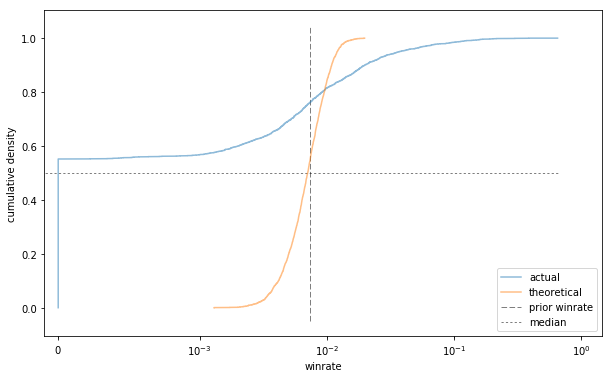

In [11]:
ax = plot_winrates(C=1000);
xlin = 10**-3
ax.set_xscale('symlog', linthreshx=xlin);
ax.set_xlim(left=-10e-5);
ax.legend(loc=4);
ax.set_xlabel('winrate');

This porridge is too cold!

We're very confident in our 0.74% win rate this time, so we rarely pick any probabilities that stray too far from it. Unlike the previous sample (and the observed data), the sample from this Beta distribution has a median very close to our prior winrate.

(Why is the observed median so low? Because of how it is. It's just a fact that lots of players have never won a game, or rarely win. The overall winrate of 0.74% is misleading, as means often are. The top 1% of players, with winrates over 12%, do a lot to bring up the average (just as the very wealthy may bring up the mean household income well above the median).)

Let's try a few values of C in between.

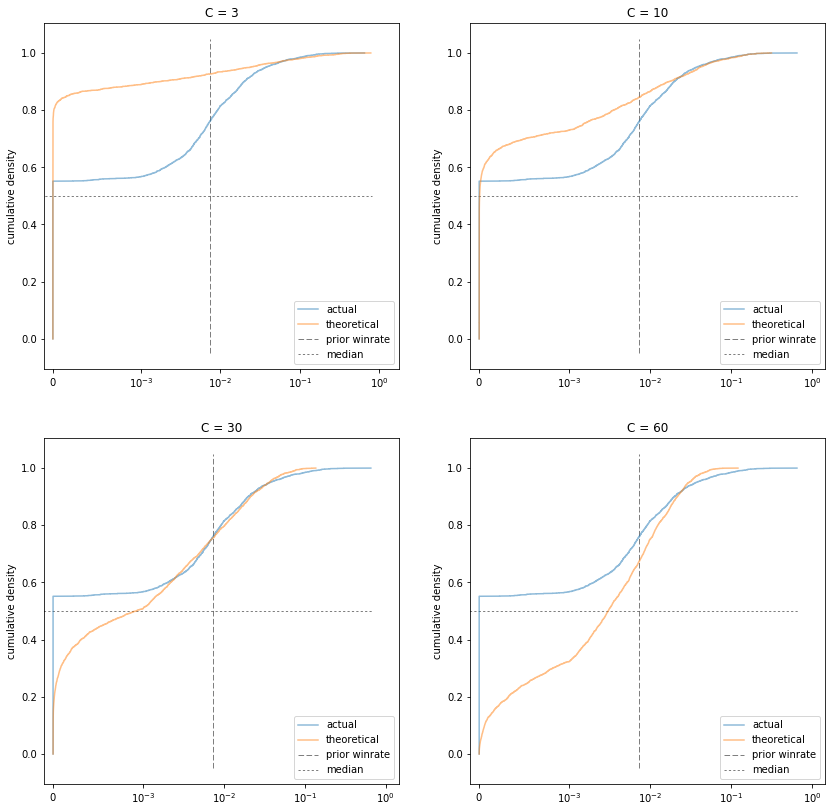

In [12]:
Cs = [3, 10, 30, 60]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
for (C, ax) in zip(Cs, axes.flatten()):
    ax = plot_winrates(C=C, ax=ax);
    xlin = 10**-3
    ax.set_xscale('symlog', linthreshx=xlin);
    ax.set_xlim(left=-10e-5);
    ax.set_title('C = {}'.format(C))
    ax.legend(loc=4);

C=30 certainly looks like the winner. And that is in fact the value I ended up using for the smoothed win rates I used in my [other](/blog/dcss_players) [posts](/blog/dcss_newbie_traps).

The only problem is that it seems to assign too much weight to small non-zero probabilities, and slightly too little weight to high probabilities.

Or does it? Remember that the observed win rates are *not* actual samples from the distribution we're trying to model (the true win rates of DCSS players). They're noisy samples. The noisiness is mostly not a big deal, since we're only looking at players with at least 100 games.

*However*, if your true win rate is 1 in 1,000, or 1 in 10,000, then your win rate over 100 games will be a *very* noisy estimate of your true win rate. Our sample has a lot of players with 0% win rates. Lots of those players must have a small but non-zero chance of winning (a monkey randomly mashing the keyboard for eternity would probably win eventually), but those win rates are very hard to measure. (The lowest observed win rate in the data is 1.2e-4, or about 1 in 10,000).

As for underestimating high win rates, I'm not too worried. It could be a real problem. It could be that sampling effects are also causing an overrepresentation of high win rates. It could be that high win rates are overrepresented among players with at least 100 games. But the discrepancy is not huge, and I'd rather be conservative about guessing a high win rate given a small number of games.

"Try a bunch of different parameter settings, graph some samples from the distribution under those parameters, and choose the one that looks the best" doesn't quite have the ring of scientific rigour to it, but it at least feels better than picking a number out of a hat. The more principled thing to do would be to do gradient descent to approximate the maximum likelihood estimate for C. But that sounds like an ordeal.

Here's the distribution of smoothed winrates across games (assigning to each game the winrate of the corresponding player), compared to raw win rate.

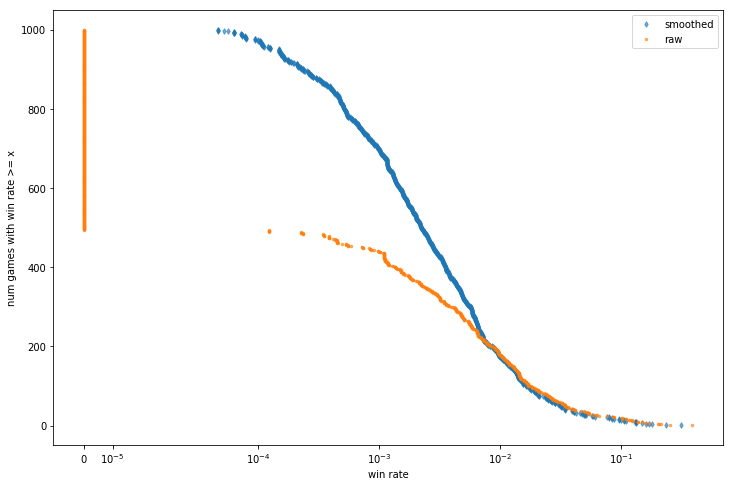

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
order = -1
plot_kwargs = dict(lw=0, alpha=.6)
n = 1000
seed = 1337
if n:
    ax.plot(np.sort(g['wr'].sample(n, random_state=seed))[::order], 
            np.arange(n)+1, 
            label='smoothed', marker='d', ms=4,
            **plot_kwargs
           );
    ax.plot(np.sort(g['raw winrate'].sample(n, random_state=seed))[::order], 
            np.arange(n)+1, 
            label='raw', marker='.', ms=5,
            **plot_kwargs
           );
else:
    ax.plot(np.sort(g['wr'])[::order], np.arange(len(g))+1, label='smoothed', ms=40, alpha=1,
            **plot_kwargs
           );
    ax.plot(np.sort(g['raw winrate'])[::order], np.arange(len(g))+1, label='raw', ms=5, alpha=1,
            **plot_kwargs
           );
xlin = g['wr'].min()
#xlin = rwrpp[rwrpp > 0].min()
ax.set_xscale('symlog', linthreshx=xlin)
ax.set_xlabel('win rate')
ax.set_ylabel('num games with win rate >= x')
ax.legend();
#ax.set_ylim(bottom=-10000);

Smooth!

In [14]:
# Overall win rates conditioned on number of games played. 
if 0:
    gpp = games_per_pid = g.groupby('pid').size()
    wr_per_gp = g.groupby(gpp.loc[g['pid']].values)['won'].mean()
    wr_per_gp[:10].plot.bar(figsize=FS)